<a href="https://colab.research.google.com/github/bc1414/Machine-Learning-Notes/blob/main/GCN_on_SIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing package and import package
In this project, we need to install two package. One is networkx, which can be used to construct a specific type of network. The another advanatage of the Networkx is we can directly call the adjacency matrix. Another package we used is Pytorch, which is used to build GCN for predicting status of nodes on SIR model.

In [ ]:
!pip install networkx
!pip3 install torch==1.6.0+cu101 torchvision==0.7.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html



Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 15kB/s 
     |████████████████████████████████| 5.8MB 712kB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import math
import time
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim

# SIR model on random network

## Set a random network via NetworkX



In [ ]:
N = 1000 #number of nodes in networkx
kave = 4 #expected number of partners
print('generating graph G with {} nodes'.format(N))
print('The average degree of nodes is {}'.format(kave))
G = nx.fast_gnp_random_graph(N, kave/(N-1)) #Erdo’’s-Re’nyi graph

generating graph G with 1000 nodes
The average degree of nodes is 4


## Build a basic discrete SIR model using array operation
Parameters:
1.   Intial_infected_fraction: Percentage of nodes infected disease in network.
2.   G: NetworkX Graph.
3.   p: probablity of a suspected nodes get infected in one timestep
4.   r: probablity of a infected nodes get recovered in one timestep

Return:

1.   S_history: List of the history of all nodes in network about whether
they are in *S* state. The order of the nodes is [n1,n2,n3....] Stored as binary form. 1 represnt node is in s state, 0 is not.
2.   I_history: List of the history of all state in network about whether they are in *I* state. The order of the nodes is [n1,n2,n3....] Stored as binary form. 1 represnt node is I state, 0 is not.
3.   R_history: List of the history of all state in network about whether they are in *R* state. The order of the nodes is [n1,n2,n3....] Stored as binary form. 1 represnt node is R state, 0 is not.

In [ ]:
def SIR_model(initial_infected_fraction,G,p,r):
  S_history=[]
  I_history=[]
  R_history=[]
  N=len(G.nodes())# Number of nodes in network
  N_ii=round(initial_infected_fraction*N) # Only integer number of nodes are allowed
  intial_patients=random.sample(list(G.nodes()), N_ii)# Randomly select patient
  infected_status=np.zeros(N)
  infected_status[intial_patients]=1 # Create an initial array which is infected
  recover_status=np.zeros(N,dtype=np.int8)
  s_state=np.ones(N,dtype=np.int8)
  s_state=np.greater(s_state,infected_status) # Update for infected
  A = nx.adjacency_matrix(G).todense()
  A=np.squeeze(np.asarray(A))
  infected_status=np.squeeze(np.asarray(infected_status))
  t=0# Create timestemp
  while np.sum(infected_status)>1:
    t+=1
    recover_from_disease=np.random.rand(N)*infected_status>(1-r * infected_status)
    # Generate RNG to compute people recovered.
    recover_status+=recover_from_disease
    # One nodes can only be infected once and can be used for unit test
    infected_status[recover_status>0]=0
    # Masked for boolean to remove the infected nodes
    infect_prob=np.dot(A,infected_status)*p
    # Take consideration of network topology to compute probablity of all nodes
    # are infected.
    infected_new=np.random.rand(N)>(1-infect_prob *s_state)
    infected_status+= infected_new
    # Compute new infected nodes
    s_state=np.greater(s_state,infected_status)

    S_history.append(s_state.tolist())
    I_history.append(infected_status.tolist())
    R_history.append(recover_status.tolist())

  plt.plot(np.arange(t),np.sum(I_history,axis=1),label='Infected')
  plt.plot(np.arange(t),np.sum(R_history,axis=1),label='Recovered')
  plt.plot(np.arange(t),np.sum(S_history,axis=1),label='Suscepted')
  plt.xlabel('Timestep')
  plt.ylabel('Number of population')
  plt.legend()
  return S_history,I_history,R_history


## Execute the code and unit test

To ensure the code is done correctly, we can build some unit test. The first one is that the node must be one of the state *s, i *or *r*, therefore, column sum must be equal to the number of population. In addition, the row sum of all states must be equal to number of timesteps *t*.

In addition, visual check for evaultion of the population against time evolution is also added.


PS: Another check manually which may be simpler, such as the change of recovered population on average should approximately equal to recovery rate $\times$ infected population but not implemented here.

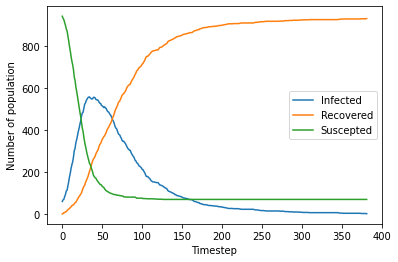

In [ ]:
s,i,r=SIR_model(0.05,G,0.05,0.02)

In [ ]:
def unit_test(S,I,R,N):
  sir=np.sum(S,axis=1)+np.sum(I,axis=1)+np.sum(R,axis=1)==N
  assert sir.all()==True
  assert np.sum(S+I+R)==N*len(R)
  print('unit test past')

unit_test(s,i,r,N)

Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
print('{} nodes is not in Largest Connected Component, \
they may not be affected during the breakout if the initial patient not in the \
component'.format(N-len(G0.nodes())))


unit test past
15 nodes is not in Largest Connected Component, they may not be affected during the breakout if the initial patient not in the component


## One hot Encoding was used to transfer feature
Since our output is alrealy what we want so we can just combine them. Otherwise, we can use one hot encoding from *scikit-learn*. In addition, we transfered data into pytorch tensor flow form.

Reference Link:

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

***combine_feature***:

Produce one hot encoding for all history of nodes.

Input:

1.   S_history
2.   I_history
3.   R_history

Output:

1. combined_feature_list: One hot encoded feature(states of noes) for all nodes in history.



------------------
***label_feature_extraction***:

Select a particular timestep to train and test neural network.

Input:

1.   t: a given timestep
2.   combine_feature_list: a list contain all features in hisory

Output:

1. list: One hot encoded feature(states of noes) for features in history and transformed into the tensor form.

In [ ]:
import torch
def combine_feature(s,i,r):
  # Equivalent to 1-hot encoding
  Combine_feature=[]
  for time_index in range(len(s)):
    combined_feature=np.stack((s[time_index],i[time_index],r[time_index]),axis=1)
    Combine_feature.append(combined_feature)
  return Combine_feature


c=combine_feature(s,i,r)
def label_feature_extraction(t,combined_feature_list):
  feature=torch.FloatTensor(combined_feature_list[t])
  label=torch.FloatTensor(combined_feature_list[t+1])
  return feature,label
labels,features=label_feature_extraction(23,c)

# Normalize the adjacency matrix and compute $ \hat{A}=D^{-0.5}\tilde{A}D^{-0.5}$.
Normlize accoding to raw sum(sometimes known as the transition matrix while computing adjacency matrix). Notice, in SIR model the knowledge about him self is also imortant and therefore, we added a self-loop to it yousing sp eye(creating identity matrix).

In [ ]:
import numpy as np
import scipy.sparse as sp
import torch

def normalize(matrix):
    row_sum = np.array(matrix.sum(1))
    r_inv = np.power(row_sum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    matrix = r_mat_inv.dot(matrix)
    return matrix

def preprocessing_data(A):
    A = normalize(A + sp.eye(A.shape[0]))
    A= torch.FloatTensor(A)
    return A
def kronecker_weight_data(Pk,A)

A=nx.adj_matrix(G)
A=preprocessing_data(A.todense())


## Design GCN-layer and initialize the two layer neural network

$Z=f(X,A)=\mathrm{softmax} (\hat{A} ReLU(\hat{A}XW^0) W^1)$



In [ ]:
class GCN_layer(nn.Module):
  def __init__(self, in_features, out_features):
        super(GCN_layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        weight = torch.FloatTensor(self.in_features, self.out_features)
        self.weight = nn.Parameter(weight)  # nn.Parameter is a Tensor that's a module parameter.
        self.weight.data.uniform_() # uniform initial weight but it seems not matter
  def forward(self, input, A):
        WX = torch.mm(input, self.weight)
        AWX = torch.mm(A, WX)
        return AWX
class GCN(nn.Module):
    def __init__(self, num_features, num_hidden_units, num_class, dropout):
        super(GCN, self).__init__()
        self.gc1 = GCN_layer(num_features, num_hidden_units)
        self.gc2 = GCN_layer(num_hidden_units, num_class)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, A))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, A)
        return F.log_softmax(x, dim=1)




## Train model for one dataset (cuda can be used but this case is really simple so no need to call GPU)



              precision    recall  f1-score   support

           S       0.92      0.92      0.92       141
           I       0.92      0.88      0.90       137
           R       0.74      0.91      0.82        22

    accuracy                           0.90       300
   macro avg       0.86      0.90      0.88       300
weighted avg       0.90      0.90      0.90       300



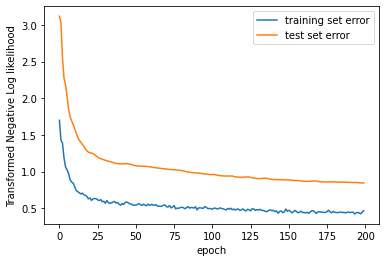

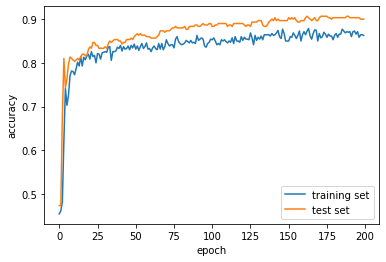

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

idx_train=torch.LongTensor(np.arange(N*0.7))
idx_test=torch.LongTensor(np.arange(N*0.7,N))
# Set a seed so we can reproduce result
torch.manual_seed(55)

# Load data


# Model and optimizer
model = GCN(num_features=features.shape[1],
            num_hidden_units=32,
            num_class=3,
            dropout=0.5)
optimizer = optim.Adam(model.parameters(),
                       lr=0.05, weight_decay=0.0005)


def train(epoch):
    model.train()
    optimizer.zero_grad()
    output = model(features, A)
    loss_train = F.nll_loss(output[idx_train],torch.max(labels[idx_train], 1)[1])
    accuracy_train=accuracy_score(torch.max(output[idx_train],1)[1], torch.max(labels[idx_train],1)[1])
    loss_train.backward()
    optimizer.step()
    model.eval()
    output = model(features, A)
    loss_test = F.nll_loss(output[idx_test],torch.max(labels[idx_test], 1)[1])
    accuracy_test=accuracy_score(torch.max(output[idx_test],1)[1], torch.max(labels[idx_test],1)[1])
    return loss_train,loss_test,accuracy_train,accuracy_test,output



# Train model
train_loss_list=[]
test_loss_list=[]
acc_train=[]
acc_test=[]
for epoch in range(200):
    train_loss,test_loss,accuracy_train,accuracy_test,output=train(epoch)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    acc_train.append(accuracy_train)
    acc_test.append(accuracy_test)

from sklearn.metrics import classification_report
target_names = ['S', 'I', 'R']
print(classification_report(torch.max(output[idx_test],1)[1], torch.max(labels[idx_test],1)[1], target_names=target_names))
plt.figure()
plt.plot(range(200), np.array(train_loss_list)/0.7,label='training set error')
plt.plot(range(200),np.array(test_loss_list)/0.3,label='test set error')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Transformed Negative Log likelihood')
plt.figure()
plt.plot(range(200), np.array(acc_train),label='training set')
plt.plot(range(200), np.array(acc_test),label='test set')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
from sklearn.model_selection import train_test_split
idx_train=torch.LongTensor(np.arange(N*0.7))
idx_test=torch.LongTensor(np.arange(N*0.7,N))
# Set a seed so we can reproduce result
torch.manual_seed(55)

# Load data

# Model and optimizer



def train(model,epoch,features,idx_train,idx_test,labels):
    model.train()
    optimizer.zero_grad()
    output = model(features, A)
    loss_train = F.nll_loss(output[idx_train],torch.max(labels[idx_train], 1)[1])
    accuracy_train=accuracy_score(torch.max(output[idx_train],1)[1], torch.max(labels[idx_train],1)[1])


    loss_train.backward()
    optimizer.step()

    model.eval()

    output = model(features, A)

    loss_test = F.nll_loss(output[idx_test],torch.max(labels[idx_test], 1)[1])
    accuracy_test=accuracy_score(torch.max(output[idx_test],1)[1], torch.max(labels[idx_test],1)[1])
    return loss_train,loss_test,accuracy_train,accuracy_test,output


ensemble_result_train=[]
ensemble_result_test=[]
for idx in range(200,300):
  labels,features=label_feature_extraction(idx,c)
# Train model
  train_loss_list=[]
  test_loss_list=[]

  model = GCN(num_features=features.shape[1],
            num_hidden_units=32,
            num_class=3,
            dropout=0.5)

  optimizer = optim.Adam(model.parameters(),
                       lr=0.05, weight_decay=0.0005)

  for epoch in range(200):
    loss_train,loss_test,accuracy_train,accuracy_test,output=train(model=model,epoch=epoch,features=features,idx_train=idx_train,idx_test=idx_test,labels=labels)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)


  target_names = ['S', 'I', 'R']
  print(classification_report(torch.max(output[idx_test],1)[1], torch.max(labels[idx_test],1)[1], target_names=target_names))
  ensemble_result_train.append(train_loss_list)
  ensemble_result_test.append(test_loss_list)




              precision    recall  f1-score   support

           S       0.96      1.00      0.98        24
           I       0.50      0.50      0.50         6
           R       0.99      0.99      0.99       270

    accuracy                           0.98       300
   macro avg       0.82      0.83      0.82       300
weighted avg       0.98      0.98      0.98       300

              precision    recall  f1-score   support

           S       0.96      1.00      0.98        24
           I       0.67      0.57      0.62         7
           R       0.99      0.99      0.99       269

    accuracy                           0.98       300
   macro avg       0.87      0.85      0.86       300
weighted avg       0.98      0.98      0.98       300

              precision    recall  f1-score   support

           S       0.96      1.00      0.98        24
           I       0.83      0.62      0.71         8
           R       0.99      0.99      0.99       268

    accuracy        

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           S       0.96      1.00      0.98        24
           I       0.00      0.00      0.00         1
           R       1.00      1.00      1.00       275

    accuracy                           0.99       300
   macro avg       0.65      0.67      0.66       300
weighted avg       0.99      0.99      0.99       300

              precision    recall  f1-score   support

           S       1.00      1.00      1.00        25
           I       0.00      0.00      0.00         1
           R       1.00      1.00      1.00       274

    accuracy                           1.00       300
   macro avg       0.67      0.67      0.67       300
weighted avg       0.99      1.00      1.00       300

              precision    recall  f1-score   support

           S       1.00      1.00      1.00        25
           I       0.00      0.00      0.00         1
           R       1.00      1.00      1.00       274

    accuracy        

## 简单聊聊
总体模型表现的还可以，判定S状态的nodes表现相对最好，期望之中， S状态周围规律最明显，如果周围没有I或者都是R本身判定比较容易。 R的判定其次，基本是基于前一个时间状态和随机性，所以在一开始几个时间片段表现不尽人意，因为所有的结果都只能随机等S状态节点恢复。 I的判定随机性会最大，所以各个时间段预测准确率偏低。不同网络尚未测试，但应该结果类似。